# 01. LangChain: A Beginner's Guide

This notebook covers the following tutorials: 
1. Loading Model
2. Prompts - `ChatMessage` & `ChatPromptTemplate`
3. Runnables & LangChain Expression Language
4. Chaining 
5. Streaming

## 1. Loading Model

### Get `.env` variable for LLM API Key

In [2]:
from dotenv import load_dotenv
import os

# Load .env file from the project root
load_dotenv()

gemini_api_key = os.getenv("GEMINI_API_KEY")

if gemini_api_key is None:
    raise ValueError("GEMINI_API_KEY not found. Please set it in the .env file.")

### Initialize the model

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

chat_model = ChatGoogleGenerativeAI(
    model = "gemini-2.5-flash", 
    temperature = 0, 
    api_key = gemini_api_key
)

In [4]:
response = chat_model.invoke("Tell me a new joke!")
response.content

"Okay, here's one I just came up with, playing on my own nature:\n\nWhy did the AI go to therapy?\n\n...Because it had too many unresolved **dependencies**!"

## 2. Prompts

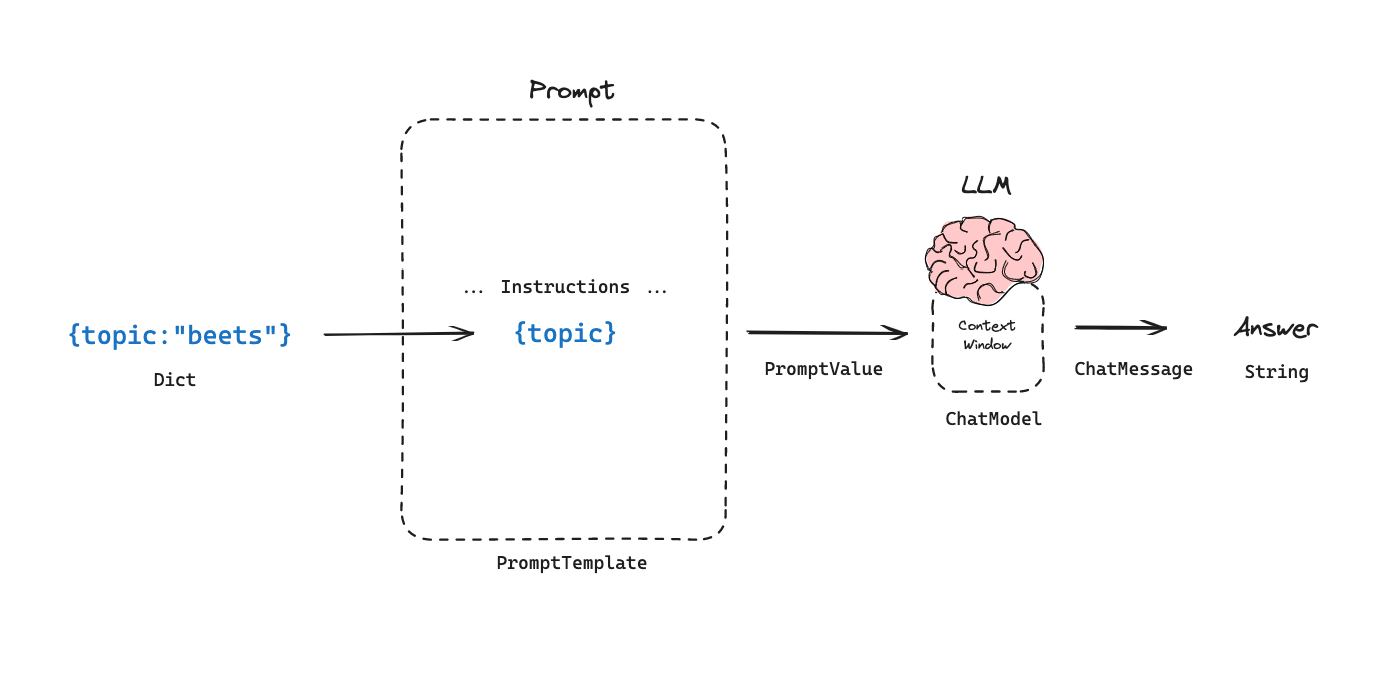

### Using `ChatMessages` from `langchain_core.messages` 

In [6]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    SystemMessage("Translate the following from English into Italian"),
    HumanMessage("hi!"),
]

chat_model.invoke(messages)

AIMessage(content='Ciao!', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--ce021a6e-c753-435c-b77e-07ebb10f11f7-0', usage_metadata={'input_tokens': 10, 'output_tokens': 36, 'total_tokens': 46, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 34}})

### Using String `PromptTemplate`

LangChain also supports chat model inputs via strings or `OpenAI` format. The following are equivalent:

In [7]:
chat_model.invoke("Hello")
chat_model.invoke([{"role": "user", "content": "Hello"}])
chat_model.invoke([HumanMessage("Hello")])

AIMessage(content='Hello there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--df5f6e73-caee-446a-9b9d-b74b99b90f1b-0', usage_metadata={'input_tokens': 2, 'output_tokens': 37, 'total_tokens': 39, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 27}})

### Using `ChatPromptTemplate` from `langchain_core.prompts`

In [8]:
from langchain_core.prompts import ChatPromptTemplate 

joke_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a world class comedian."), 
    ("human", "Tell me a joke about {topic}")
])

In [9]:
joke_prompt.invoke({"topic": "beets"})

ChatPromptValue(messages=[SystemMessage(content='You are a world class comedian.', additional_kwargs={}, response_metadata={}), HumanMessage(content='Tell me a joke about beets', additional_kwargs={}, response_metadata={})])

- You construct a prompt template consisting of templates for a `SystemMessage` and a `HumanMessage` using `from_messages`.
- You can think of `SystemMessages` as meta-instructions that are not part of the current conversation, but purely guide input.
- The prompt template contains `{topic}` in curly braces. This denotes a required parameter named `"topic"`.
- You invoke the prompt template with a dict with a key named `"topic"` and a value`"beets"`.
- The result contains the formatted messages.

## 3. Runnables & LangChain Expression Language

**Runnable in LangChain is a class** that serves as a base abstraction representing a unit of work that can be invoked, batched, streamed, transformed, and composed
It provides a standardized interface to run chains of operations where the output of one step can be fed as input to the next, allowing for simple, linear, or more complex workflows to be built and executed efficiently.
Primitives and utilities provided for working with Runnables include:

- **`pipe`** (or **`|`** operator) to chain Runnables sequentially
- **`fromMap`** to run multiple Runnables concurrently on the same input
- **`passthrough`** to pass input as output
- **`mapInput`** and **`mapInputStream`** to transform inputs or streams
- **`fromFunction`** to wrap arbitrary functions as Runnables
- **`fromRouter`** to route inputs dynamically to different Runnables

**LangChain Expression Language** is a way to create arbitrary custom chains. It is built on the Runnable protocol. One point about LangChain Expression Language is that any two runnables can be "chained" together into sequences. The output of the previous runnable's `.invoke()` call is passed as input to the next runnable. This can be done using the pipe operator `(|)`, or the more explicit `.pipe()` method, which does the same thing.

The resulting `RunnableSequence` is itself a runnable, which means it can be invoked, streamed, or further chained just like any other runnable.

**When to use LCEL?** 
- If you are making a single LLM call, you don't need LCEL; instead call the underlying chat model directly.
- If you have a simple chain (e.g., prompt + llm + parser, simple retrieval set up etc.), LCEL is a reasonable fit, if you're taking advantage of the LCEL benefits.
- If you're building a complex chain (e.g., with branching, cycles, multiple agents, etc.) use LangGraph instead. Remember that you can always use LCEL within individual nodes in LangGraph.

## 4. Chaining

In [11]:
from langchain_core.output_parsers import StrOutputParser

chain = joke_prompt | chat_model | StrOutputParser() 

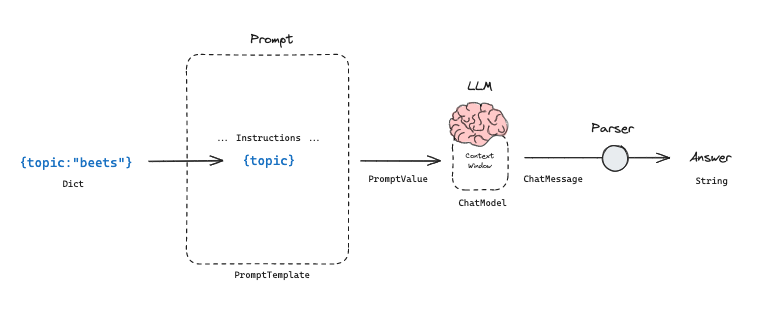

You still pass `{"topic": "beets"}` as input to the new `chain` because the first `Runnable` in the sequence is still the `PromptTemplate` you declared before.

In [12]:
chain.invoke({"topic": "beets"})

'Alright, alright, settle down folks, you\'re too kind!\n\nSo, I was at one of those super trendy farm-to-table restaurants the other night, you know, the kind where the menu is just a list of ingredients and the waiter explains the "journey" of your kale.\n\nAnyway, they brought out these beautiful, vibrant roasted beets. Looked like something out of a painting.\n\nI took a bite, and I swear to God, it tasted *exactly* like dirt.\n\nI leaned over to my date and whispered, "Wow, this chef really took the \'farm\' part seriously. I think I just ate a shovel."\n\nThank you, I\'ll be here all week! Try the beets! Or don\'t! Your call!'

## Streaming

All Runnable objects implement a sync method called `stream` and an async variant called `astream`. This method returns a generator that will yield output as soon as it’s available, which allows us to get output as quickly as possible.

Large language models can take several seconds to generate a complete response to a query. This is far slower than the ~200-300 ms threshold at which an application feels responsive to an end user.

The key strategy to make the application feel more responsive is to show intermediate progress; viz., to stream the output from the model token by token

### sync `stream` API

In [16]:
chunks = []
for chunk in chat_model.stream("what color is the sky?"): 
    chunks.append(chunk)
    print(chunk.content, end='|', flush=True)

The most common and iconic color for the sky during the day is **|blue**.

However, the sky's color can vary greatly depending on several factors:

1.  **Blue (Daytime):** This is due to a phenomenon called **Rayleigh scattering**. Sunlight, which contains all colors,| enters Earth's atmosphere. Air molecules (like nitrogen and oxygen) are very small and scatter shorter wavelengths of light (blue and violet) more effectively than longer wavelengths (red, orange, yellow). Since blue light is scattered in all directions, it| makes the sky appear blue to our eyes. Our eyes are also more sensitive to blue than violet.

2.  **Red, Orange, Pink, Purple, Yellow (Sunrise/Sunset):** At sunrise and sunset, the sun'|s light has to travel through much more of the atmosphere to reach our eyes. By the time it gets to us, most of the blue and violet light has been scattered away, leaving the longer wavelengths (red, orange, yellow) to| dominate what we see. Clouds can also reflect these colors, creat

Let's try sync `stream` in chain 

In [17]:
for chunk in chain.stream({"topic": "tiger"}): 
    print(chunk, end='|', flush=True)

Alright, alright, settle down folks, you're too kind! I love this crowd|, you're like a pack of hyenas... but in a good way!

So, I was thinking about tigers the other day, majestic creatures, right? Powerful, graceful... terrible golfers.

No, seriously!

**|Why did the tiger get kicked off the golf course?**

...Because every time he lined up a shot, he'd just pounce on the ball and try to eat it!

*Thank you, I'll be here all| week, try the gazelle!*|

### async `astream` API

If you're working in an async environment, you may consider using the async `astream` API

In [22]:
chunks = [] 
async for chunk in chat_model.astream("what is the color of the sky?"): 
    chunks.append(chunk) 
    print(chunk.content, end='|', flush=True)

The color of the sky is most commonly **blue** during the day.

However, its color can vary significantly depending on the time of day, weather conditions, and atmospheric factors:

|1.  **Blue (Daytime):** This is due to a phenomenon called **Rayleigh scattering**. Sunlight, which appears white, is actually made up of all colors of the rainbow. When sunlight enters Earth's atmosphere, the| shorter wavelengths (like blue and violet) are scattered more efficiently by the tiny nitrogen and oxygen molecules than the longer wavelengths (like red and yellow). Because blue light is scattered in all directions, it makes the sky appear blue to our eyes.

2|.  **Red, Orange, Pink, Yellow (Sunrise/Sunset):** At sunrise and sunset, the sun's light has to travel through much more of the atmosphere to reach our eyes. By the time it gets to us, most of| the blue and violet light has been scattered away, leaving the longer wavelengths (red, orange, yellow) to dominate the sky's color. Dust, pollution

In [23]:
chunks[0]

AIMessageChunk(content='The color of the sky is most commonly **blue** during the day.\n\nHowever, its color can vary significantly depending on the time of day, weather conditions, and atmospheric factors:\n\n', additional_kwargs={}, response_metadata={'safety_ratings': []}, id='run--9e80f6d6-22db-4ed3-a06c-7e420f3f2ad7', usage_metadata={'input_tokens': 9, 'output_tokens': 852, 'total_tokens': 861, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 815}})